# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
from IPython.display import Audio
import os,random

from sklearn.preprocessing   import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import SVC
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')


features_folder = '/Users/harin_khakhi/Desktop/ML/Data'
genres_folder   = '/Users/harin_khakhi/Desktop/ML/Data/genres_original'

# Importing Data

In [2]:
def get_data(filename):
    data = pd.read_csv(filename)
    X = data.drop(['length','label','filename','perceptr_mean','perceptr_var'], axis=1)
    y = data['label']
    return X,y,data

In [3]:
dataset = f'{features_folder}/features_30_sec.csv'
X, y, whole_data = get_data(dataset)

In [4]:
print(X.shape, y.shape)
print(X.columns)

(1000, 55) (1000,)
Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'tempo', 'mfcc1_mean', 'mfcc1_var',
       'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean',
       'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var',
       'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean',
       'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var',
       'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean',
       'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var',
       'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean',
       'mfcc19_var', 'mfcc20_mean', 'mfcc20_var'],
      dtype='object')


# Preprocessing Data

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [6]:
genres = encoder.inverse_transform(range(0,10))
for ind in range(10):
    print(ind, ' : ', genres[ind])

0  :  blues
1  :  classical
2  :  country
3  :  disco
4  :  hiphop
5  :  jazz
6  :  metal
7  :  pop
8  :  reggae
9  :  rock


# Data Visualization

In [7]:
def genre_finder(string, genre):
    return string.find(genre)!=-1

def get_random_songs(genre, num=10):
    if( not (genre in genres) ):
        return songs
    
    bools = whole_data.filename.apply(genre_finder, args=(genre,)) 

    all_songs = whole_data[bools]
    
    return (all_songs.sample(num))
    
def get_songs(genre):
    if( not (genre in genres) ):
        return songs
    
    bools = whole_data.filename.apply(genre_finder, args=(genre,)) 

    all_songs = whole_data[bools]
    return all_songs
    
genre_songs = dict()
for genre in genres:
    genre_songs[genre] = get_songs(genre)

# Splitting Data

In [8]:
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)

(1000, 55)
(1000,)


In [9]:
print(X_train.shape, y_train.shape)

(750, 55) (750,)


# Fitting Model

In [10]:
def get_metrics(model, name):
    print(classification_report(y_test, model.predict(X_test)))
    
    confusion_mat = confusion_matrix(y_test, model.predict(X_test))
    confusion_df = pd.DataFrame(confusion_mat, index=genres, columns=genres)
    ax = plt.axes()
    sns.heatmap(confusion_df, annot=True,cmap="OrRd", ax=ax)
    ax.set_title(f'{name} Confusion Matrix')

              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.89      0.86      0.88        29
           2       0.81      0.74      0.77        23
           3       0.72      0.69      0.71        26
           4       0.69      0.67      0.68        30
           5       0.73      0.76      0.75        25
           6       0.89      0.80      0.84        30
           7       0.91      0.91      0.91        22
           8       0.57      0.57      0.57        23
           9       0.52      0.64      0.57        22

   micro avg       0.75      0.75      0.75       250
   macro avg       0.75      0.75      0.75       250
weighted avg       0.75      0.75      0.75       250

Support Vector Classifier Model Accuracy :  0.748


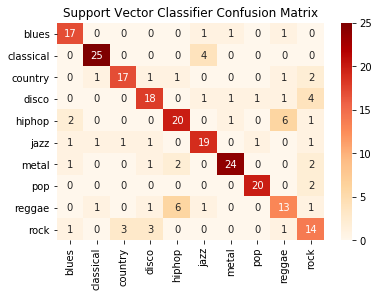

In [15]:
support_vector_classifier = SVC(probability=True)

params = {
            'C' : [0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly']
         }
support_vector_classifier = GridSearchCV(support_vector_classifier, params)

support_vector_classifier.fit(X_train, y_train)

get_metrics(support_vector_classifier, 'Support Vector Classifier')

print('Support Vector Classifier Model Accuracy : ', support_vector_classifier.score(X_test, y_test))

# 30sec Dataset => Support Vector Classifier Model Accuracy :  0.72
# 3 sec Dataset => Support Vector Classifier Model Accuracy :  0.74

In [16]:
print(support_vector_classifier.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [17]:
report = {
        'Logistic Regression' : [0.725,0.737, 0.728] ,
        'KNN Classification'  : [0.64, 0.62 , 0.62],
        'Support Vector Classifier' : [ 0.77,0.78,0.77]
}
report = pd.DataFrame(report, index=['precision', 'recall', 'f1-score'])
display(report)

,Logistic Regression,KNN Classification,Support Vector Classifier
precision,0.725,0.64,0.77
recall,0.737,0.62,0.78
f1-score,0.728,0.62,0.77


## Support Vector Classifier Param Search

In [19]:
C_ = [0.01, 0.1, 1, 10, 100, 1000]
accs = []
for c in C_:
    support_vector_classifier = SVC(C=c)
    support_vector_classifier.fit(X_train, y_train)
    accs.append(support_vector_classifier.score(X_test, y_test))

Text(0.5, 1.0, 'Regularization vs Accuracy')

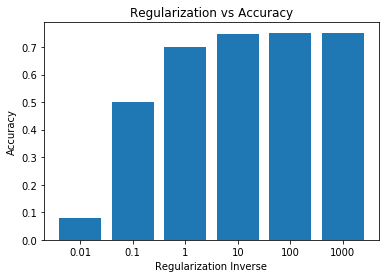

In [20]:
import matplotlib.pyplot as plt
cstr = []
for c in C_:
    cstr.append(str(c))
plt.bar(cstr, accs)
plt.xlabel('Regularization Inverse')
plt.ylabel('Accuracy')
plt.title('Regularization vs Accuracy')

# Testing Model

In [21]:
def get_features(my_data):
    features = {}

    features['length']                   = len(my_data)
    
    features['chroma_stft_mean']         = np.mean(librosa.feature.chroma_stft(my_data))
    features['chroma_stft_var']          = np.var(librosa.feature.chroma_stft(my_data))

    features['rms_mean']                 = np.mean(librosa.feature.rms(my_data))
    features['rms_var']                  = np.var(librosa.feature.rms(my_data))

    features['spectral_centroid_mean']   = np.mean(librosa.feature.spectral_centroid(my_data))
    features['spectral_centroid_var']    = np.var(librosa.feature.spectral_centroid(my_data))

    features['spectral_bandwidth_mean']  = np.mean(librosa.feature.spectral_bandwidth(my_data))
    features['spectral_bandwidth_var']   = np.var(librosa.feature.spectral_bandwidth(my_data))
    
    features['rolloff_mean']             = np.mean(librosa.feature.spectral_rolloff(my_data))
    features['rolloff_var']              = np.var(librosa.feature.spectral_rolloff(my_data))
    
    features['zero_crossing_rate_mean']  = np.mean(librosa.feature.zero_crossing_rate(my_data))
    features['zero_crossing_rate_var']   = np.var(librosa.feature.zero_crossing_rate(my_data))
    
    features['harmony_mean']             = np.mean(librosa.effects.harmonic(my_data))
    features['harmony_var']              = np.var(librosa.effects.harmonic(my_data))

    features['tempo']                    = librosa.beat.tempo(my_data)
    
    mfccs = librosa.feature.mfcc(my_data)
    for ind, row in enumerate(mfccs):
        features[f'mfcc{ind+1}_mean']      = np.mean(mfccs[ind])
        features[f'mfcc{ind+1}_var']       = np.var(mfccs[ind])
    return features

In [22]:
def predict(music_file):
    music_data,sr = librosa.load(music_file, duration=30.0)
    features = get_features(music_data)
    features = pd.DataFrame(features)
    features = scaler.transform(features)
    return encoder.inverse_transform(model.predict(features))